In [ ]:
#
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
#

In [1]:
# Import libraries
from pyomo.environ import *
from pyomo.dae import *
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# load flow rate data
flow_data = pd.read_csv('flow_data.csv')
lc_data = pd.read_csv('lc_data.csv')
teaf      = 0.00721
teaden    = 0.728
cBf = teaf

In [3]:
tQf = np.insert(flow_data['t'].values, 0, 0)
Qf = np.insert(flow_data["Qf"].values / teaden, 0, 0)

In [4]:
tlc = lc_data['t'].values
lc = lc_data['lc_meas'].values

In [5]:
tout = np.sort(np.unique(np.concatenate((tQf, tlc))))

In [6]:
Qf_if = interp1d(tQf, Qf, 'previous', bounds_error = False)
lc_if = interp1d(tlc, lc, 'previous', bounds_error = False)

In [7]:
data = [{'tout': tout, 'tlc': tlc, 'Qf_if': Qf_if, 'lc':lc, 'cBf': cBf}]

In [21]:
def bvsm_model(data):
    
    tout = data['tout']
    tlc = data['tlc']
    Qf_if = data['Qf_if']
    lc_m = data['lc']
    cBf = data['cBf']
    
    Vr0 = 2370
    
    m = ConcreteModel()
    
    m.k = Var(initialize = 2, bounds = (1e-2, 10))
    m.nA0 = Var(initialize = 2.35, bounds = (2, 3))
    
    m.time = ContinuousSet(bounds = (0, max(tout)), initialize = tout)
    
    m.Vr = Var(m.time, initialize = Vr0, bounds = (Vr0,None))
    m.reps2 = Var(m.time, initialize = 0)
    m.y = Var(m.time, initialize = 0.5, bounds = (0, 1))
    
    m.dVr = DerivativeVar(m.Vr)
    m.dreps2 = DerivativeVar(m.reps2)
    
    def _dVr_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dVr[t] == float(Qf_if(t))
    m.dVr_eq = Constraint(m.time, rule = _dVr_eq)
    
    def _dreps2_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            Badded = (m.Vr[t] - Vr0) * cBf
            expr1 = m.k * (m.nA0 - Badded + m.reps2[t]) / (Badded - 2 * m.reps2[t] + 1e-6)
            return m.dreps2[t] == float(Qf_if(t)) * cBf / (1.0 + expr1)
        m.dreps2_eq = Constraint(m.time, rule = _dreps2_eq)
    
    def _ycalc(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            Badded = (m.Vr[t] - Vr0) * cBf
            nD = m.reps2[t]
            nC = Badded - 2 * nD
            return m.y[t] == nC / (nC + 2 * nD + 1.0e-6)
    m.ycalc = Constraint(m.time, rule = _ycalc)
    
    def _initcon(m):
        yield m.Vr[m.time.first()] == Vr0
        yield m.reps2[m.time.first()] == 0.0
    m.initcon = ConstraintList(rule = _initcon)
    
    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
#        return sum((float(lc_if(t)) / m.y[t] - 1.0) ** 2 for t in tlc) 
        return sum((float(lc_if(t)) - m.y[t]) ** 2 for t in tlc) 
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)
   
    def total_cost_rule(model):
        return model.FirstStageCost + model.SecondStageCost
    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    #disc = TransformationFactory('dae.collocation')
    #disc.apply_to(m, nfe=200, ncp=2)
    
    disc = TransformationFactory('dae.finite_difference')
    disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m

In [22]:
# parameters to be estimated
theta_names = ['k', 'nA0']

In [23]:
pest = parmest.Estimator(bvsm_model, data, theta_names, tee = True)

In [24]:
obj, theta = pest.theta_est()

Ipopt 3.11.1: max_iter=6000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5006
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1535

Total number of variables............................:     2506
                     variables with only lower bounds:      501
                variables with lower and upper bou

In [25]:
theta

{'k': 5.005000045, 'nA0': 2.500000005}

In [26]:
ms = bvsm_model(data[0])
ms.k.fix(theta['k'])
ms.nA0.fix(theta['nA0'])
solver = SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5002
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1535

Total number of variables............................:     2502
                     variables with only lower bounds:      501
                variables with lower and upper bounds:      500


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2002, 'Number of variables': 2502, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.15245509147644043}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

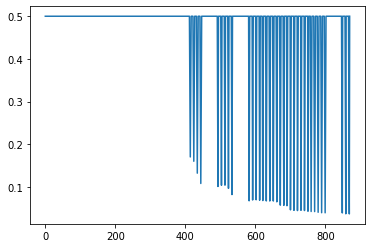

In [30]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.y[t]() for t in ms.time])
#ax.scatter(data[0]['tlc'], data[0]['lc'])
#ax.set_xlim(400, 900)
#ax.set_ylim(0, 0.2)